<a name="top"></a>
# **HW15 Meta Learning: Few-shot Classification**

This is the sample code for homework 15.

Please mail to mlta-2023-spring@googlegroups.com if you have any questions.

## **Step 0: Check GPU**

In [1]:
!nvidia-smi

Mon Jul  3 13:14:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  Off |
|  0%   44C    P8    22W / 450W |      6MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Step 1: Download Data**

Run the cell to download data, which has been pre-processed by TAs.  
The dataset has been augmented, so extra data augmentation is not required.


In [2]:
workspace_dir = '.'

# Download dataset
# !wget https://www.dropbox.com/s/pqeym3n4jly5e89/Omniglot.tar.gz?dl=1 \
#     -O "{workspace_dir}/Omniglot.tar.gz"
# !wget https://www.dropbox.com/s/nlvokertmksfc42/Omniglot-test.tar.gz?dl=1 \
#     -O "{workspace_dir}/Omniglot-test.tar.gz"

# # Use `tar' command to decompress
# !tar -zxf "{workspace_dir}/Omniglot.tar.gz" -C "{workspace_dir}/"
# !tar -zxf "{workspace_dir}/Omniglot-test.tar.gz" -C "{workspace_dir}/"

## **Step 2: Build the model**

### Library importation

In [3]:
# Import modules we need
import glob, random
from collections import OrderedDict

import numpy as np
from tqdm.auto import tqdm

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

from PIL import Image
from IPython.display import display

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"DEVICE = {device}")

# Fix random seeds
random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

/home/yuehpo/miniconda3/envs/hw15/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEVICE = cuda


### Model Construction Preliminaries

Since our task is image classification, we need to build a CNN-based model.  
However, to implement MAML algorithm, we should adjust some code in `nn.Module`.


Take a look at MAML pseudocode...

<img src="https://i.imgur.com/9aHlvfX.png" width="50%" />

On the 10-th line, what we take gradients on are those $\theta$ representing  
<font color="#0CC">**the original model parameters**</font> (outer loop) instead of those in  the  
<font color="#0C0">**inner loop**</font>, so we need to use `functional_forward` to compute the output  
logits of input image instead of `forward` in `nn.Module`.

The following defines these functions.

<!-- 由於在第10行，我們是要對原本的參數 θ 微分，並非 inner-loop (Line5~8) 的 θ' 微分，因此在 inner-loop，我們需要用 functional forward 的方式算出 input image 的 output logits，而不是直接用 nn.module 裡面的 forward（直接對 θ 微分）。在下面我們分別定義了 functional forward 以及 forward 函數。 -->

### Model block definition

In [4]:
def ConvBlock(in_ch: int, out_ch: int):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )


def ConvBlockFunction(x, w, b, w_bn, b_bn):
    x = F.conv2d(x, w, b, padding=1)
    x = F.batch_norm(
        x, running_mean=None, running_var=None, weight=w_bn, bias=b_bn, training=True
    )
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    return x

### Model definition

In [5]:
class Classifier(nn.Module):
    def __init__(self, in_ch, k_way):
        super(Classifier, self).__init__()
        self.conv1 = ConvBlock(in_ch, 64)
        self.conv2 = ConvBlock(64, 64)
        self.conv3 = ConvBlock(64, 64)
        self.conv4 = ConvBlock(64, 64)
        self.logits = nn.Linear(64, k_way)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.shape[0], -1)
        x = self.logits(x)
        return x

    def functional_forward(self, x, params):
        """
        Arguments:
        x: input images [batch, 1, 28, 28]
        params: model parameters,
                i.e. weights and biases of convolution
                     and weights and biases of
                                   batch normalization
                type is an OrderedDict

        Arguments:
        x: input images [batch, 1, 28, 28]
        params: The model parameters,
                i.e. weights and biases of convolution
                     and batch normalization layers
                It's an `OrderedDict`
        """
        for block in [1, 2, 3, 4]:
            x = ConvBlockFunction(
                x,
                params[f"conv{block}.0.weight"],
                params[f"conv{block}.0.bias"],
                params.get(f"conv{block}.1.weight"),
                params.get(f"conv{block}.1.bias"),
            )
        x = x.view(x.shape[0], -1)
        x = F.linear(x, params["logits.weight"], params["logits.bias"])
        return x

### Create Label

This function is used to create labels.  
In a N-way K-shot few-shot classification problem,
each task has `n_way` classes, while there are `k_shot` images for each class.  
This is a function that creates such labels.


In [6]:
def create_label(n_way, k_shot):
    return torch.arange(n_way).repeat_interleave(k_shot).long()


# Try to create labels for 5-way 2-shot setting
create_label(5, 2)

tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])

### Accuracy calculation

In [7]:
def calculate_accuracy(logits, labels):
    """utility function for accuracy calculation"""
    acc = np.asarray(
        [(torch.argmax(logits, -1).cpu().numpy() == labels.cpu().numpy())]
    ).mean()
    return acc

### Define Dataset

Define the dataset.  
The dataset returns images of a random character, with (`k_shot + q_query`) images,  
so the size of returned tensor is `[k_shot+q_query, 1, 28, 28]`.  


In [8]:
# Dataset for train and val
class Omniglot(Dataset):
    def __init__(self, data_dir, k_shot, q_query, task_num=None):
        self.file_list = [
            f for f in glob.glob(data_dir + "**/character*", recursive=True)
        ]
        # limit task number if task_num is set
        if task_num is not None:
            self.file_list = self.file_list[: min(len(self.file_list), task_num)]
            
        self.transform = transforms.Compose([
            # transforms.RandomResizedCrop(size=84),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
        ])
        
        self.n = k_shot + q_query

    def __getitem__(self, idx):
        # For random sampling the characters we want.
        img_path = self.file_list[idx]
        img_list = [f for f in glob.glob(img_path + "**/*.png", recursive=True)]
        img_list.sort()

        sample = np.arange(len(img_list))
        np.random.shuffle(sample)

        # `k_shot + q_query` examples for each character
        imgs = [self.transform(Image.open(img_list[idx])) for idx in sample[:self.n]]
        imgs = torch.stack(imgs)
        return imgs

    def __len__(self):
        return len(self.file_list)

## **Step 3: Learning Algorithms**

### Transfer learning

The solver first chose five task from the training set, then do normal classification training on the chosen five tasks. In inference, the model finetune for `inner_train_step` steps on the support set images, and than do inference on the query set images.

For consistant with the meta-learning solver, the base solver has the exactly same input and output format with the meta-learning solver.



In [9]:
def BaseSolver(
    model,
    optimizer,
    x,
    n_way,
    k_shot,
    q_query,
    loss_fn,
    inner_train_step=1,
    inner_lr=0.4,
    train=True,
    return_labels=False,
):
    criterion, task_loss, task_acc = loss_fn, [], []
    labels = []

    for meta_batch in x:
        # Get data
        support_set = meta_batch[: n_way * k_shot]
        query_set = meta_batch[n_way * k_shot :]

        if train:
            """ training loop """
            # Use the support set to calculate loss
            labels = create_label(n_way, k_shot).to(device)
            logits = model.forward(support_set)
            loss = criterion(logits, labels)

            task_loss.append(loss)
            task_acc.append(calculate_accuracy(logits, labels))
        else:
            """ validation / testing loop """
            # First update model with support set images for `inner_train_step` steps
            fast_weights = OrderedDict(model.named_parameters())


            for inner_step in range(inner_train_step):
                # Simply training
                train_label = create_label(n_way, k_shot).to(device)
                logits = model.functional_forward(support_set, fast_weights)
                loss = criterion(logits, train_label)

                grads = torch.autograd.grad(loss, fast_weights.values(), create_graph=True)
                # Perform SGD
                fast_weights = OrderedDict(
                    (name, param - inner_lr * grad)
                    for ((name, param), grad) in zip(fast_weights.items(), grads)
                )

            if not return_labels:
                """ validation """
                val_label = create_label(n_way, q_query).to(device)

                logits = model.functional_forward(query_set, fast_weights)
                loss = criterion(logits, val_label)
                task_loss.append(loss)
                task_acc.append(calculate_accuracy(logits, val_label))
            else:
                """ testing """
                logits = model.functional_forward(query_set, fast_weights)
                labels.extend(torch.argmax(logits, -1).cpu().numpy())

    if return_labels:
        return labels

    batch_loss = torch.stack(task_loss).mean()
    task_acc = np.mean(task_acc)

    if train:
        # Update model
        model.train()
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    return batch_loss, task_acc

### Meta Learning

Here is the main Meta Learning algorithm.

Please finish the TODO blocks for the inner and outer loop update rules.

- For implementing FO-MAML you can refer to [p.25 of the slides](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2019/Lecture/Meta1%20(v6).pdf#page=25&view=FitW).

- For the original MAML, you can refer to [the slides of meta learning (p.13 ~ p.18)](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2019/Lecture/Meta1%20(v6).pdf#page=13&view=FitW).


In [10]:
# MAML
def MetaSolver(
    model,
    optimizer,
    x,
    n_way,
    k_shot,
    q_query,
    loss_fn,
    inner_train_step=1,
    inner_lr=0.4,
    train=True,
    return_labels=False
):
    criterion, task_loss, task_acc = loss_fn, [], []
    labels = []

    for meta_batch in x:
        # Get data
        support_set = meta_batch[: n_way * k_shot]
        query_set = meta_batch[n_way * k_shot :]

        # Copy the params for inner loop
        fast_weights = OrderedDict(model.named_parameters())

        ### ---------- INNER TRAIN LOOP ---------- ###
        for inner_step in range(inner_train_step):
            # Simply training
            train_label = create_label(n_way, k_shot).to(device)
            logits = model.functional_forward(support_set, fast_weights)
            loss = criterion(logits, train_label)

            # Compute gradients
            gradients = torch.autograd.grad(loss, fast_weights.values(), create_graph=True)

            # Inner gradients update! vvvvvvvvvvvvvvvvvvvv #
            """ Inner Loop Update """
            fast_weights = OrderedDict(
                (name, param - inner_lr * grad)
                for ((name, param), grad) in zip(fast_weights.items(), gradients)
            )
            # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ #

        ### ---------- INNER VALID LOOP ---------- ###
        if not return_labels:
            """ training / validation """
            val_label = create_label(n_way, q_query).to(device)

            # Collect gradients for outer loop
            logits = model.functional_forward(query_set, fast_weights)
            loss = criterion(logits, val_label)
            task_loss.append(loss)
            task_acc.append(calculate_accuracy(logits, val_label))
        else:
            """ testing """
            logits = model.functional_forward(query_set, fast_weights)
            labels.extend(torch.argmax(logits, -1).cpu().numpy())

    if return_labels:
        return labels

    # Update outer loop
    model.train()
    optimizer.zero_grad()

    meta_batch_loss = torch.stack(task_loss).mean()
    if train:
        """ Outer Loop Update """
        meta_batch_loss.backward()  # compute gradients of meta loss with respect to model parameters
        optimizer.step()  # perform a gradient update step

    task_acc = np.mean(task_acc)
    return meta_batch_loss, task_acc


## **Step 4: Initialization**

After defining all components we need, the following initialize a model before training.

### Hyperparameters

In [18]:
n_way = 5
k_shot = 1
q_query = 1
train_inner_train_step = 1
val_inner_train_step = 3
inner_lr = 0.4
meta_lr = 0.001
meta_batch_size = 32
max_epoch = 50
eval_batches = 20
train_data_path = "./Omniglot/images_background/"

### Dataloader initialization

In [19]:
def dataloader_init(datasets, shuffle=True, num_workers=2):
    train_set, val_set = datasets
    train_loader = DataLoader(
        train_set,
        # The "batch_size" here is not \
        #    the meta batch size, but  \
        #    how many different        \
        #    characters in a task,     \
        #    i.e. the "n_way" in       \
        #    few-shot classification.
        batch_size=n_way,
        num_workers=num_workers,
        shuffle=shuffle,
        drop_last=True,
    )
    val_loader = DataLoader(
        val_set, batch_size=n_way, num_workers=num_workers, shuffle=shuffle, drop_last=True
    )

    train_iter = iter(train_loader)
    val_iter = iter(val_loader)
    return (train_loader, val_loader), (train_iter, val_iter)

### Model & optimizer initialization

In [20]:
def model_init():
    meta_model = Classifier(1, n_way).to(device)
    optimizer = torch.optim.Adam(meta_model.parameters(), lr=meta_lr)
    loss_fn = nn.CrossEntropyLoss().to(device)
    return meta_model, optimizer, loss_fn

### Utility function to get a meta-batch

In [21]:
def get_meta_batch(meta_batch_size, k_shot, q_query, data_loader, iterator):
    data = []
    for _ in range(meta_batch_size):
        try:
            # a "task_data" tensor is representing \
            #     the data of a task, with size of \
            #     [n_way, k_shot+q_query, 1, 28, 28]
            task_data = next(iterator)
        except StopIteration:
            iterator = iter(data_loader)
            task_data = next(iterator)
        train_data = task_data[:, :k_shot].reshape(-1, 1, 28, 28)
        val_data = task_data[:, k_shot:].reshape(-1, 1, 28, 28)
        task_data = torch.cat((train_data, val_data), 0)
        data.append(task_data)
    return torch.stack(data).to(device), iterator

<a name="mainprog" id="mainprog"></a>
## **Step 5: Main program for training & testing**

### Start training!
With `solver = 'base'`, the solver is a transfer learning algorithm.

Once you finish the TODO blocks in the `MetaSolver`, change the variable `solver = 'meta'` to start training with meta learning algorithm.


In [22]:
solver = 'meta' # base, meta
meta_model, optimizer, loss_fn = model_init()

# init solver and dataset according to solver type
if solver == 'base':
    max_epoch = 5 # the base solver only needs 5 epochs
    Solver = BaseSolver
    train_set, val_set = torch.utils.data.random_split(
        Omniglot(train_data_path, k_shot, q_query, task_num=10), [5, 5]
    )
    (train_loader, val_loader), (train_iter, val_iter) = dataloader_init((train_set, val_set), shuffle=False)

elif solver == 'meta':
    Solver = MetaSolver
    dataset = Omniglot(train_data_path, k_shot, q_query)
    train_split = int(0.8 * len(dataset))
    val_split = len(dataset) - train_split
    train_set, val_set = torch.utils.data.random_split(
        dataset, [train_split, val_split]
    )
    (train_loader, val_loader), (train_iter, val_iter) = dataloader_init((train_set, val_set))
else:
    raise NotImplementedError


# main training loop
for epoch in range(max_epoch):
    print("Epoch %d" % (epoch + 1))
    train_meta_loss = []
    train_acc = []
    # The "step" here is a meta-gradinet update step
    for step in tqdm(range(max(1, len(train_loader) // meta_batch_size))):
        x, train_iter = get_meta_batch(
            meta_batch_size, k_shot, q_query, train_loader, train_iter
        )
        meta_loss, acc = Solver(
            meta_model,
            optimizer,
            x,
            n_way,
            k_shot,
            q_query,
            loss_fn,
            inner_train_step=train_inner_train_step
        )
        train_meta_loss.append(meta_loss.item())
        train_acc.append(acc)
    print("  Loss    : ", "%.3f" % (np.mean(train_meta_loss)), end="\t")
    print("  Accuracy: ", "%.3f %%" % (np.mean(train_acc) * 100))

    # See the validation accuracy after each epoch.
    # Early stopping is welcomed to implement.
    val_acc = []
    for eval_step in tqdm(range(max(1, len(val_loader) // (eval_batches)))):
        x, val_iter = get_meta_batch(
            eval_batches, k_shot, q_query, val_loader, val_iter
        )
        # We update three inner steps when testing.
        _, acc = Solver(
            meta_model,
            optimizer,
            x,
            n_way,
            k_shot,
            q_query,
            loss_fn,
            inner_train_step=val_inner_train_step,
            train=False,
        )
        val_acc.append(acc)
    print("  Validation accuracy: ", "%.3f %%" % (np.mean(val_acc) * 100))

Epoch 1


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


  Loss    :  2.830	  Accuracy:  24.844 %


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


  Validation accuracy:  37.000 %
Epoch 2


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


  Loss    :  1.547	  Accuracy:  31.875 %


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


  Validation accuracy:  30.000 %
Epoch 3


100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


  Loss    :  1.427	  Accuracy:  39.219 %


100%|██████████| 1/1 [00:00<00:00,  6.47it/s]


  Validation accuracy:  38.000 %
Epoch 4


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


  Loss    :  1.366	  Accuracy:  43.906 %


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


  Validation accuracy:  47.000 %
Epoch 5


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


  Loss    :  1.324	  Accuracy:  45.000 %


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


  Validation accuracy:  43.000 %
Epoch 6


100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


  Loss    :  1.322	  Accuracy:  46.719 %


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


  Validation accuracy:  42.000 %
Epoch 7


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


  Loss    :  1.303	  Accuracy:  44.844 %


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


  Validation accuracy:  41.000 %
Epoch 8


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


  Loss    :  1.254	  Accuracy:  48.594 %


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


  Validation accuracy:  45.000 %
Epoch 9


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


  Loss    :  1.229	  Accuracy:  50.000 %


100%|██████████| 1/1 [00:00<00:00,  6.30it/s]


  Validation accuracy:  46.000 %
Epoch 10


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


  Loss    :  1.240	  Accuracy:  47.500 %


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


  Validation accuracy:  50.000 %
Epoch 11


100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


  Loss    :  1.203	  Accuracy:  52.969 %


100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


  Validation accuracy:  46.000 %
Epoch 12


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


  Loss    :  1.165	  Accuracy:  52.188 %


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


  Validation accuracy:  44.000 %
Epoch 13


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


  Loss    :  1.135	  Accuracy:  53.125 %


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


  Validation accuracy:  54.000 %
Epoch 14


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


  Loss    :  1.110	  Accuracy:  53.750 %


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


  Validation accuracy:  44.000 %
Epoch 15


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


  Loss    :  1.095	  Accuracy:  54.531 %


100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


  Validation accuracy:  54.000 %
Epoch 16


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


  Loss    :  1.109	  Accuracy:  55.625 %


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


  Validation accuracy:  48.000 %
Epoch 17


100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


  Loss    :  1.048	  Accuracy:  56.563 %


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


  Validation accuracy:  48.000 %
Epoch 18


100%|██████████| 4/4 [00:00<00:00,  5.70it/s]


  Loss    :  1.041	  Accuracy:  59.219 %


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


  Validation accuracy:  55.000 %
Epoch 19


100%|██████████| 4/4 [00:00<00:00,  4.48it/s]


  Loss    :  1.016	  Accuracy:  60.938 %


100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


  Validation accuracy:  53.000 %
Epoch 20


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


  Loss    :  1.004	  Accuracy:  62.031 %


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


  Validation accuracy:  57.000 %
Epoch 21


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


  Loss    :  0.943	  Accuracy:  63.594 %


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


  Validation accuracy:  60.000 %
Epoch 22


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


  Loss    :  0.935	  Accuracy:  65.625 %


100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


  Validation accuracy:  50.000 %
Epoch 23


100%|██████████| 4/4 [00:00<00:00,  4.48it/s]


  Loss    :  0.955	  Accuracy:  63.750 %


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


  Validation accuracy:  66.000 %
Epoch 24


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


  Loss    :  0.965	  Accuracy:  63.906 %


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


  Validation accuracy:  55.000 %
Epoch 25


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


  Loss    :  0.895	  Accuracy:  66.406 %


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


  Validation accuracy:  59.000 %
Epoch 26


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


  Loss    :  0.911	  Accuracy:  65.312 %


100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


  Validation accuracy:  59.000 %
Epoch 27


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


  Loss    :  0.876	  Accuracy:  65.938 %


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


  Validation accuracy:  54.000 %
Epoch 28


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


  Loss    :  0.826	  Accuracy:  70.938 %


100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


  Validation accuracy:  67.000 %
Epoch 29


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


  Loss    :  0.848	  Accuracy:  67.812 %


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


  Validation accuracy:  59.000 %
Epoch 30


100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


  Loss    :  0.808	  Accuracy:  70.469 %


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


  Validation accuracy:  64.000 %
Epoch 31


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


  Loss    :  0.752	  Accuracy:  73.750 %


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


  Validation accuracy:  63.000 %
Epoch 32


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


  Loss    :  0.799	  Accuracy:  67.500 %


100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


  Validation accuracy:  71.000 %
Epoch 33


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


  Loss    :  0.736	  Accuracy:  73.750 %


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


  Validation accuracy:  64.000 %
Epoch 34


100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


  Loss    :  0.706	  Accuracy:  74.688 %


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


  Validation accuracy:  71.000 %
Epoch 35


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


  Loss    :  0.706	  Accuracy:  72.188 %


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


  Validation accuracy:  66.000 %
Epoch 36


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


  Loss    :  0.736	  Accuracy:  73.594 %


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


  Validation accuracy:  77.000 %
Epoch 37


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


  Loss    :  0.657	  Accuracy:  74.844 %


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


  Validation accuracy:  76.000 %
Epoch 38


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


  Loss    :  0.651	  Accuracy:  75.000 %


100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


  Validation accuracy:  64.000 %
Epoch 39


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


  Loss    :  0.641	  Accuracy:  75.625 %


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


  Validation accuracy:  69.000 %
Epoch 40


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


  Loss    :  0.649	  Accuracy:  77.188 %


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


  Validation accuracy:  70.000 %
Epoch 41


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


  Loss    :  0.631	  Accuracy:  77.812 %


100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


  Validation accuracy:  81.000 %
Epoch 42


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


  Loss    :  0.622	  Accuracy:  78.281 %


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


  Validation accuracy:  74.000 %
Epoch 43


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


  Loss    :  0.620	  Accuracy:  78.438 %


100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


  Validation accuracy:  84.000 %
Epoch 44


100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


  Loss    :  0.564	  Accuracy:  79.375 %


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


  Validation accuracy:  68.000 %
Epoch 45


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


  Loss    :  0.608	  Accuracy:  76.250 %


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


  Validation accuracy:  75.000 %
Epoch 46


100%|██████████| 4/4 [00:01<00:00,  4.00it/s]


  Loss    :  0.603	  Accuracy:  77.969 %


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


  Validation accuracy:  77.000 %
Epoch 47


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


  Loss    :  0.587	  Accuracy:  77.812 %


100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


  Validation accuracy:  80.000 %
Epoch 48


100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


  Loss    :  0.591	  Accuracy:  78.594 %


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


  Validation accuracy:  76.000 %
Epoch 49


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


  Loss    :  0.559	  Accuracy:  81.094 %


100%|██████████| 1/1 [00:00<00:00,  6.71it/s]


  Validation accuracy:  80.000 %
Epoch 50


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


  Loss    :  0.544	  Accuracy:  79.219 %


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

  Validation accuracy:  82.000 %


### Testing the result

Since the testing data is sampled by TAs in advance, you should not change the code in `OmnigloTest` dataset, otherwise your score may not be correct on the Kaggle leaderboard.

However, fell free to chagne the variable `inner_train_step` to set the training steps on the query set images.

In [23]:
import os

# test dataset
class OmniglotTest(Dataset):
    def __init__(self, test_dir):
        self.test_dir = test_dir
        self.n = 5

        self.transform = transforms.Compose([transforms.ToTensor()])

    def __getitem__(self, idx):
        support_files = [
            os.path.join(self.test_dir, "support", f"{idx:>04}", f"image_{i}.png")
            for i in range(self.n)
        ]
        query_files = [
            os.path.join(self.test_dir, "query", f"{idx:>04}", f"image_{i}.png")
            for i in range(self.n)
        ]

        support_imgs = torch.stack(
            [self.transform(Image.open(e)) for e in support_files]
        )
        query_imgs = torch.stack([self.transform(Image.open(e)) for e in query_files])

        return support_imgs, query_imgs

    def __len__(self):
        return len(os.listdir(os.path.join(self.test_dir, "support")))

In [24]:
test_inner_train_step = 10 # you can change this

test_batches = 20
test_dataset = OmniglotTest("Omniglot-test")
test_loader = DataLoader(test_dataset, batch_size=test_batches, shuffle=False)

output = []
for _, batch in enumerate(tqdm(test_loader)):
    support_set, query_set = batch
    x = torch.cat([support_set, query_set], dim=1)
    x = x.to(device)

    labels = Solver(
        meta_model,
        optimizer,
        x,
        n_way,
        k_shot,
        q_query,
        loss_fn,
        inner_train_step=test_inner_train_step,
        train=False,
        return_labels=True,
    )

    output.extend(labels)

100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


In [25]:
# write to csv
with open("output.csv", "w") as f:
    f.write(f"id,class\n")
    for i, label in enumerate(output):
        f.write(f"{i},{label}\n")

Download the `output.csv` and submit to Kaggle!

## **Reference**
1. Chelsea Finn, Pieter Abbeel, & Sergey Levine. (2017). [Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks.](https://arxiv.org/abs/1909.09157)
1. Aniruddh Raghu, Maithra Raghu, Samy Bengio, & Oriol Vinyals. (2020). [Rapid Learning or Feature Reuse? Towards Understanding the Effectiveness of MAML.](https://arxiv.org/abs/1909.09157)


Experimenting with 32 tasks

Dataset size: 32
Epoch 1


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Epoch 2


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 3


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 4


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch 5


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 6


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 7


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 8


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 9


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Epoch 10


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch 11


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 12


100%|██████████| 1/1 [00:22<00:00, 22.45s/it]


Epoch 13


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 14


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch 15


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 16


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 17


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 18


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 19


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch 20


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


Epoch 21


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 22


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 23


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch 24


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 25


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Epoch 26


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 27


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 28


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 29


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 30


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 31


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 32


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 33


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 34


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 35


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 36


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch 37


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch 38


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 39


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 40


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 41


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 42


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 43


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 44


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 45


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 46


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch 47


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 48


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 49


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 50


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Experimenting with 128 tasks

Dataset size: 128


Epoch 1


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Epoch 2


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch 3


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Epoch 4


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch 5


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 6


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch 7


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch 8


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Epoch 9


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 10


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 11


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch 12


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Epoch 13


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 14


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 15


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch 16


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch 17


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Epoch 18


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch 19


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Epoch 20


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 21


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Epoch 22


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch 23


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 24


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 25


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Epoch 26


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch 27


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch 28


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch 29


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch 30


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Epoch 31


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch 32


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch 33


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 34


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch 35


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch 36


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch 37


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Epoch 38


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch 39


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Epoch 40


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch 41


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch 42


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch 43


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch 44


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Epoch 45


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch 46


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch 47


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch 48


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 49


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Epoch 50


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Experimenting with 512 tasks

Dataset size: 512


Epoch 1


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


Epoch 2


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch 3


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch 4


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Epoch 5


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch 6


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch 7


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Epoch 8


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Epoch 9


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch 10


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch 11


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch 12


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Epoch 13


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch 14


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch 15


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch 16


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch 17


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch 18


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch 19


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch 20


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch 21


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch 22


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch 23


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch 24


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch 25


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Epoch 26


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch 27


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch 28


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch 29


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch 30


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch 31


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch 32


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch 33


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch 34


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Epoch 35


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch 36


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Epoch 37


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Epoch 38


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch 39


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch 40


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch 41


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 42


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Epoch 43


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch 44


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch 45


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch 46


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch 47


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch 48


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch 49


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch 50


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


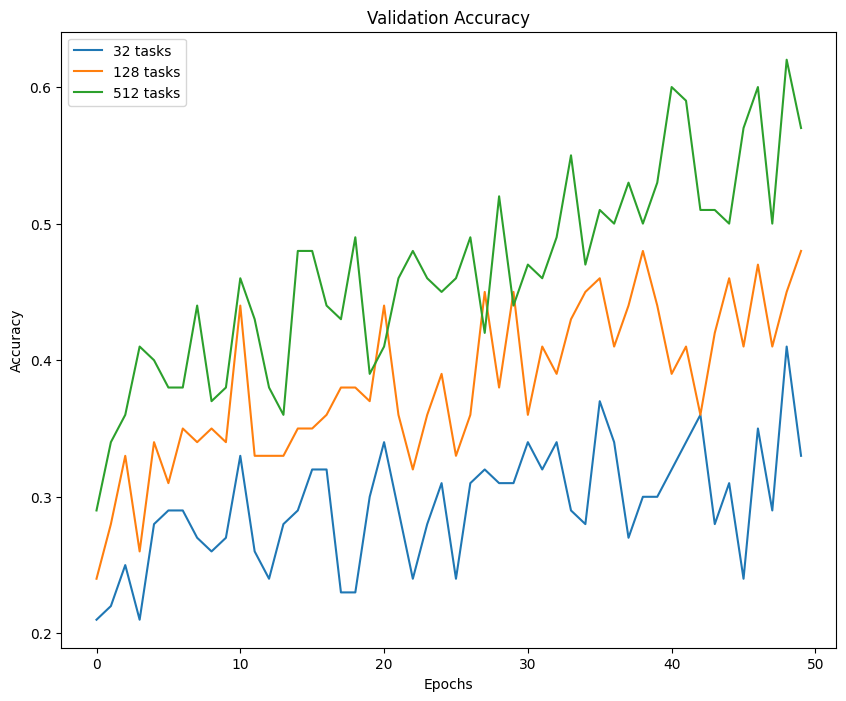

In [28]:
import matplotlib.pyplot as plt

def run_experiment(task_nums):
    results = {}
    for task_num in task_nums:
        print(f"\nExperimenting with {task_num} tasks\n")
        Solver = MetaSolver
        # Solver = BaseSolver
        dataset = Omniglot(train_data_path, k_shot, q_query, task_num=task_num) 
        # dataset = Omniglot(train_data_path, k_shot, q_query) 
        print(f"Dataset size: {len(dataset)}")
        train_split = int(0.8 * len(dataset))
        val_split = len(dataset) - train_split
        train_set, val_set = torch.utils.data.random_split(
            dataset, [train_split, val_split]
        )
        (train_loader, val_loader), (train_iter, val_iter) = dataloader_init((train_set, val_set))

        # initialize model, optimizer, and loss function according to experiment config
        meta_model, optimizer, loss_fn = model_init()
        val_acc = []

        # main training loop
        for epoch in range(max_epoch):
            print("Epoch %d" % (epoch + 1))
            train_meta_loss = []
            train_acc = []

            for step in tqdm(range(max(1, len(train_loader) // meta_batch_size))):
                x, train_iter = get_meta_batch(
                    meta_batch_size, k_shot, q_query, train_loader, train_iter
                )
                meta_loss, acc = Solver(
                    meta_model,
                    optimizer,
                    x,
                    n_way,
                    k_shot,
                    q_query,
                    loss_fn,
                    inner_train_step=train_inner_train_step
                )
                train_meta_loss.append(meta_loss.item())
                train_acc.append(acc)

            # collect validation accuracy
            for eval_step in tqdm(range(max(1, len(val_loader) // (eval_batches)))):
                x, val_iter = get_meta_batch(
                    eval_batches, k_shot, q_query, val_loader, val_iter
                )
                _, acc = Solver(
                    meta_model,
                    optimizer,
                    x,
                    n_way,
                    k_shot,
                    q_query,
                    loss_fn,
                    inner_train_step=val_inner_train_step,
                    train=False,
                )
                val_acc.append(acc)

        # Store the results
        results[task_num] = val_acc
        
        
    # Plot the results
    plt.figure(figsize=(10, 8))
    for task_num, acc in results.items():
        plt.plot(acc, label=f"{task_num} tasks")
    plt.title("Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    
        
# Set up the task numbers and experiments you are interested in
task_nums = [32, 128, 512]


run_experiment(task_nums)
